# 1. Get doctor wise accuracy

In [10]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from base_code import *

valid_data = pd.read_csv('../neurosurgeon35_data/neurosurgeon35.csv', index_col='Respondent ID')
xai25 = pd.read_csv('../computational_data/xai25.csv')


dr_wise_acc, num_mri = get_drwise_perf_metric(valid_data, xai25)

# 2. Add more info doctor wise, and save as dr_wise_acc.csv

## 2.1 add Need XAI and XAI Qual for each participant

In [2]:
# need XAI level
will_check_xai =  valid_data.filter(regex='button in the AI system').replace({"Yes":1, "No":0})
need_xai_rate_drwise = dict()
for drID in will_check_xai.index:
    row_lst = will_check_xai.loc[drID].dropna().values
    need_xai_rate_drwise[drID] = sum(row_lst) /len(row_lst)
need_xai_rate_drwise = dict(sorted(need_xai_rate_drwise.items(), key=lambda item: item[1])) 

# Explanation quality level
xai_qual = valid_data.filter(regex='How closely does the highlighted area of the color map match with your clinical judgment?').fillna(np.nan).astype(float)
xai_qual_drwise = dict()
xai_qual_drwise_std = dict()

for drID in xai_qual.index:
    row_lst = xai_qual.loc[drID].dropna().values
    xai_qual_drwise[drID] = sum(row_lst) /len(row_lst)
    xai_qual_drwise_std[drID] = np.std(row_lst)
xai_qual_drwise = dict(sorted(xai_qual_drwise.items(), key=lambda item: item[1])) 

# merge dr_wise_acc, num_mri, need_xai_rate_drwise, and xai_qual_drwise
dr_wise_acc.index.name = 'Respondent ID'
num_mri.index.name = 'Respondent ID'
num_mri = num_mri.rename(columns = {'dr': 'MRI_DR', 'AI': 'MRI_DR+AI', 'XAI': 'MRI_DR+XAI'})
dr_wise_acc = dr_wise_acc.merge(num_mri, how = 'left', left_index= True, right_index = True)

dr_wise_acc['XAI Qual'] = pd.Series(xai_qual_drwise)
dr_wise_acc['XAI Qual Std'] = pd.Series(xai_qual_drwise_std)
dr_wise_acc['Need XAI'] = pd.Series(need_xai_rate_drwise)

## 2.2 Add demographic info

In [3]:
demography_columns = ['Are you a',
 'Which medical specialty do you work in?',
    'What is your understanding of artificial intelligence (AI)?',
 'What is your opinion on incorporating AI technology into your clinical decision-making scenarios? (you may select multiple choices)',
 'Unnamed: 208',
 'Unnamed: 209',
 'Unnamed: 210',
 'Unnamed: 211',
 'Unnamed: 212',
 'Unnamed: 213',
 'How many years have you been practising medicine? (since the acquisition of your medical degree)',
 'How many years have you been practicing your {{Q2}} specialty?'
]
col_replace = {'Are you a': 'Position', 'Which medical specialty do you work in?': 'Specialty',
              'What is your understanding of artificial intelligence (AI)?': 'AI Familiarity',
              'How many years have you been practising medicine? (since the acquisition of your medical degree)': "Year of Med",
              'How many years have you been practicing your {{Q2}} specialty?': "Year of Neurosurgery",
              'What is your opinion on incorporating AI technology into your clinical decision-making scenarios? (you may select multiple choices)': 'Not interested',
              'Unnamed: 209':'Skeptical', 
              'Unnamed: 210': 'Neutral',
              'Unnamed: 211': 'Interested',
              'Unnamed: 212': 'Excited'}
attitude_col = ['Not interested', 'Skeptical', 'Neutral', 'Interested', 'Excited']
report_demography = valid_data[demography_columns]
report_demography = report_demography.rename(columns = col_replace)
report_demography['AI Attitude'] = ''
for drID in report_demography.index:
    for atti in attitude_col:
        row = report_demography.loc[drID]
        if isinstance(row[atti], str) or (not np.isnan(row[atti])):
            if len(row['AI Attitude']) ==0:
                report_demography['AI Attitude'].loc[drID] += atti
            else:
                report_demography['AI Attitude'].loc[drID] += ', {}'.format(atti)
                
                
dr_wise_acc = dr_wise_acc.merge(report_demography[['Position', 'Year of Med', 'Year of Neurosurgery', 'AI Familiarity', 'AI Attitude']], how = 'inner', left_index= True, right_index = True)
dr_wise_acc = dr_wise_acc.rename(columns = {'dr': 'DR', 'AI': 'DR+AI', 'XAI': 'DR+XAI'})
dr_wise_acc = dr_wise_acc.replace({np.nan: '', 'Resident Physician': 'Resident', 'Attending Physician': 'Attending', 'Fellow Physician':'Fellow', 
                                   'I use AI in my work or life.': 'use AI in work/life', 
                                   'I only hear of AI from the news, friends, etc.': 'hear of AI',
                                   'I have never heard of AI before': 'never hear of AI',
                                   'I can write AI code': 'can write AI code',
                                   'I can program, but I can not write AI code': 'can program, but not write AI code',
                                   'Other (please specify)': ''
                                  })

# one time code to save the data result
# dr_wise_acc.to_csv('../computational_data/dr_wise_acc.csv')

/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# 3. Report and visualize the demongraphic result

In [4]:
# report in Supplemental S2
def report_drwise_table(dr_wise_acc):
    output= ''
    for index, row in dr_wise_acc.iterrows():
        output += '{0:02d} & '.format(index)
        output += '{:.2f} & '.format(row['DR']*100)
        if row['DR+AI'] > row['DR']:
            output += '\\textbf{{{:.2f}}} & '.format(row['DR+AI']*100)
        else:
            output += '{:.2f} & '.format(row['DR+AI']*100)
        if row['DR+XAI'] > row['DR+AI']:
            output += '\\textbf{{{:.2f}}} & '.format(row['DR+XAI']*100)
        else:
            output += '{:.2f} & '.format(row['DR+XAI']*100)
        output += '{} & '.format(row['MRI_DR+XAI'])
        output += '{:.2f} & '.format(row['Need XAI']*100)
        output += '${:.2f}\pm{:.2f} $& '.format(row['XAI Qual'], row['XAI Qual Std'])
        output += '{} & '.format(row['Position'])
        if isinstance(row['Year of Neurosurgery'], float):
            output += '{:.0f} & '.format(row['Year of Neurosurgery'])
        else:
            output += ' & '
        output += '{} & '.format(row['AI Familiarity'])
        output += '{} '.format(row['AI Attitude'])
        output += '\\\ \hline \n'
    return output
output = report_drwise_table(dr_wise_acc)
print(output)

01 & 68.00 & 68.00 & \textbf{72.00} & 25 & 33.33 & $5.24\pm1.24 $& Attending & 13 & hear of AI & Skeptical \\ \hline 
02 & 66.67 & \textbf{100.00} & 100.00 & 2 & 100.00 & $5.00\pm0.00 $& Attending &  &  &  \\ \hline 
03 & 84.00 & 84.00 & 84.00 & 25 & 16.00 & $1.04\pm0.77 $& Attending & 23 & use AI in work/life & Not interested \\ \hline 
04 & 80.00 & \textbf{92.00} & 92.00 & 25 & 100.00 & $8.68\pm2.19 $& Resident & 1 & use AI in work/life & Interested \\ \hline 
05 & 88.00 & \textbf{92.00} & 92.00 & 25 & 8.70 & $7.83\pm1.03 $& Resident & 3 & hear of AI & Interested \\ \hline 
06 & 76.00 & \textbf{84.00} & \textbf{88.00} & 25 & 12.00 & $5.25\pm1.53 $& Attending & 4 & hear of AI & Skeptical \\ \hline 
07 & 84.00 & 80.00 & 80.00 & 25 & 96.00 & $6.21\pm2.24 $& Resident & 4 & hear of AI & Neutral \\ \hline 
08 & 84.00 & \textbf{96.00} & 92.00 & 25 & 28.00 & $5.04\pm2.07 $& Resident & 7 & hear of AI & Skeptical \\ \hline 
09 & 87.50 & 87.50 & \textbf{100.00} & 8 & 25.00 & $7.25\pm2.17 $& Res

In [5]:
dr_wise_acc['Position'].value_counts()

Resident     21
Attending    12
Fellow        2
Name: Position, dtype: int64

In [6]:
# report demographics
medy = np.array(valid_data['How many years have you been practising medicine? (since the acquisition of your medical degree)'].dropna().tolist()).astype(int)

print("Year of med: {:.1f}\pm{:.1f}".format(medy.mean(), medy.std()))

neuy = np.array(valid_data['How many years have you been practicing your {{Q2}} specialty?'].dropna().tolist()).astype(int)

print("Year of neuro: {:.1f}\pm{:.1f}".format(neuy.mean(), neuy.std()))


Year of med: 9.8\pm9.1
Year of neuro: 7.1\pm6.5


Yr of medicine: 9.8 ± 9.1
Yr of specialty: 7.1 ± 6.5


/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


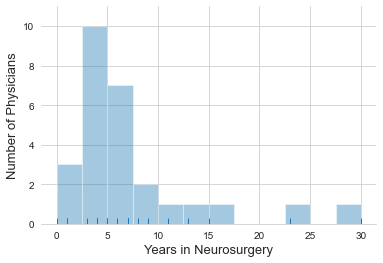

In [7]:
# Year of Specialty plot 

import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.pyplot as plt

fontsize = 13
sns.set_style("whitegrid")

yr_med = valid_data.filter(regex='How many years have you been practising medicine?').dropna().astype(int)
print("Yr of medicine: {:.1f} ± {:.1f}".format(yr_med.values.mean(), yr_med.values.std()))
yr_spe = valid_data.filter(regex='How many years have you been practicing your?').dropna().astype(int)
print("Yr of specialty: {:.1f} ± {:.1f}".format(yr_spe.values.mean(), yr_spe.values.std()))

g=sns.distplot(yr_spe, bins = 12, kde=False, rug=True, hist_kws={'range':(0,yr_spe.values.max())})
g.set_xlabel('Years in Neurosurgery', fontsize=fontsize)
g.set_ylabel('Number of Physicians',fontsize=fontsize)
sns.despine(left=True)
g.yaxis.set_major_locator(ticker.MultipleLocator(2))
# plt.savefig("../reporting/Year of Specialty.pdf", transparent=True, bbox_inches='tight')


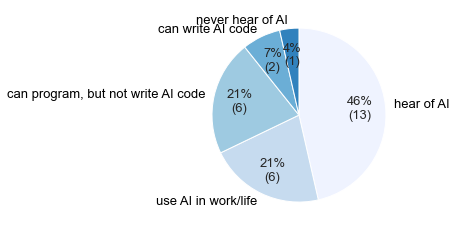

In [8]:
orange_colors = ['#eff3ff','#c6dbef','#9ecae1','#6baed6','#3182bd','#08519c']
plt.rcParams.update({'font.size': 13})
understand_ai = dr_wise_acc['AI Familiarity'].value_counts()
understand_ai = understand_ai.drop('')
patches, texts, autotexts = plt.pie(understand_ai, autopct=lambda p : '{:.0f}%\n({:,.0f})'.format(p,p * sum(understand_ai)/100),\
                                    pctdistance=0.7, labels=understand_ai.index,startangle=90,counterclock=False, colors=orange_colors)
for text in texts:
    text.set_color('black')

# plt.savefig("../reporting/understand_ai.pdf", transparent=True, bbox_inches='tight')

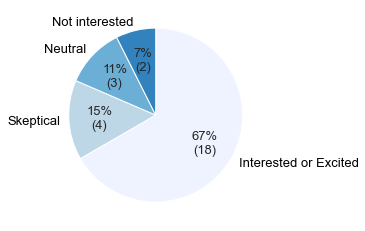

In [9]:
raw_attitude = dr_wise_acc['AI Attitude'].value_counts()
raw_attitude = raw_attitude.drop('')
raw_attitude = raw_attitude.to_dict()
blue = ['#eff3ff','#bdd7e7','#6baed6','#3182bd','#08519c']
attitude = {'Interested or Excited': 0}
for a in raw_attitude:
    if a in ['Interested', 'Excited', 'Interested, Excited']:
        attitude['Interested or Excited'] += raw_attitude[a]
    else:
        attitude[a] = raw_attitude[a]
patches, texts, autotexts = plt.pie(attitude.values(), autopct=lambda p : '{:.0f}%\n({:,.0f})'.format(p,p * sum(attitude.values())/100),\
                                    pctdistance=0.65, labels=attitude.keys(),startangle=90,counterclock=False, colors=blue)
for text in texts:
    text.set_color('black')

# plt.savefig("../reporting/attitude.pdf", transparent=True, bbox_inches='tight')